In [1]:
%run './model/multi_corpus.py'
%run './constants.py'

sns.set(rc = {'figure.figsize':(15,8)})

In [2]:
corpora = co_occurence_graphs(n_edges=100)
Gs = {field_name: corpus['G'] for (field_name, corpus) in corpora.items()}
Dfs = {field_name: corpus['Df'] for (field_name, corpus) in corpora.items()}

Gender Studies Graph with 58 nodes and 100 edges
Geometry Graph with 70 nodes and 100 edges
Geophysics Graph with 65 nodes and 100 edges
Economics Graph with 48 nodes and 100 edges
Language & Linguistics Graph with 57 nodes and 100 edges
Probability & Statistics Graph with 60 nodes and 100 edges
Material Engineering Graph with 48 nodes and 100 edges
Artificial Intelligence Graph with 50 nodes and 100 edges
Sociology Graph with 75 nodes and 100 edges
International Business Graph with 55 nodes and 100 edges
Political Science Graph with 56 nodes and 100 edges
Genetics & Genomics Graph with 72 nodes and 100 edges
Immunology Graph with 89 nodes and 100 edges
Human Resources & Organizations Graph with 67 nodes and 100 edges
Ethnic & Cultural Studies Graph with 54 nodes and 100 edges
Neurology Graph with 47 nodes and 100 edges


# Co-Occurence Graph

Gender Studies
Geometry
Geophysics
Economics
Language & Linguistics
Probability & Statistics
Material Engineering
Artificial Intelligence
Sociology
International Business
Political Science
Genetics & Genomics
Immunology
Human Resources & Organizations
Ethnic & Cultural Studies
Neurology


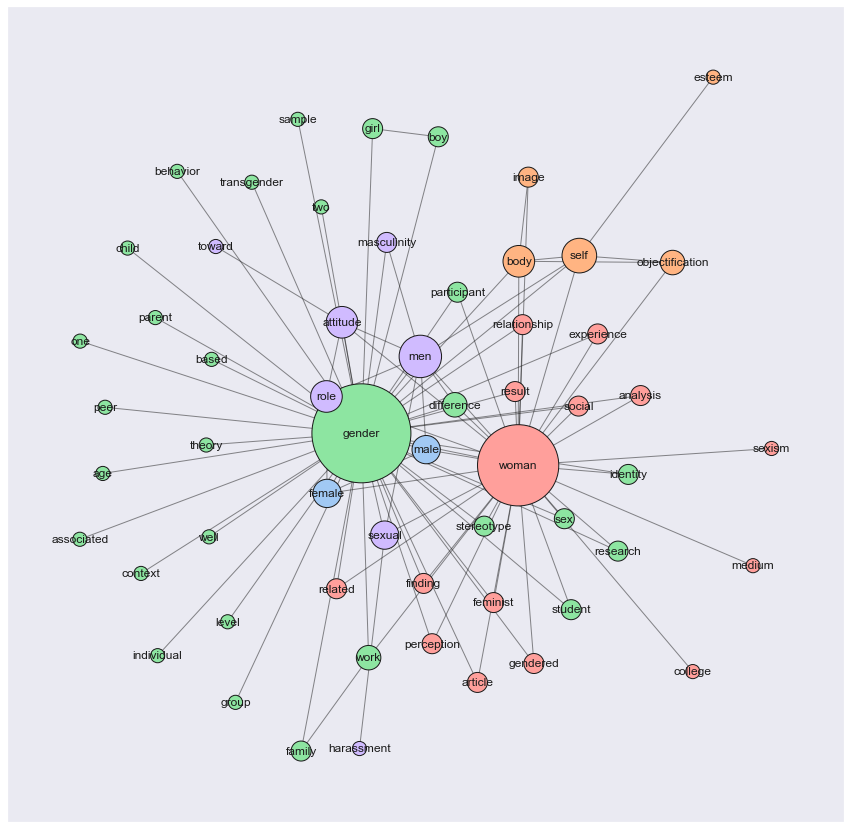

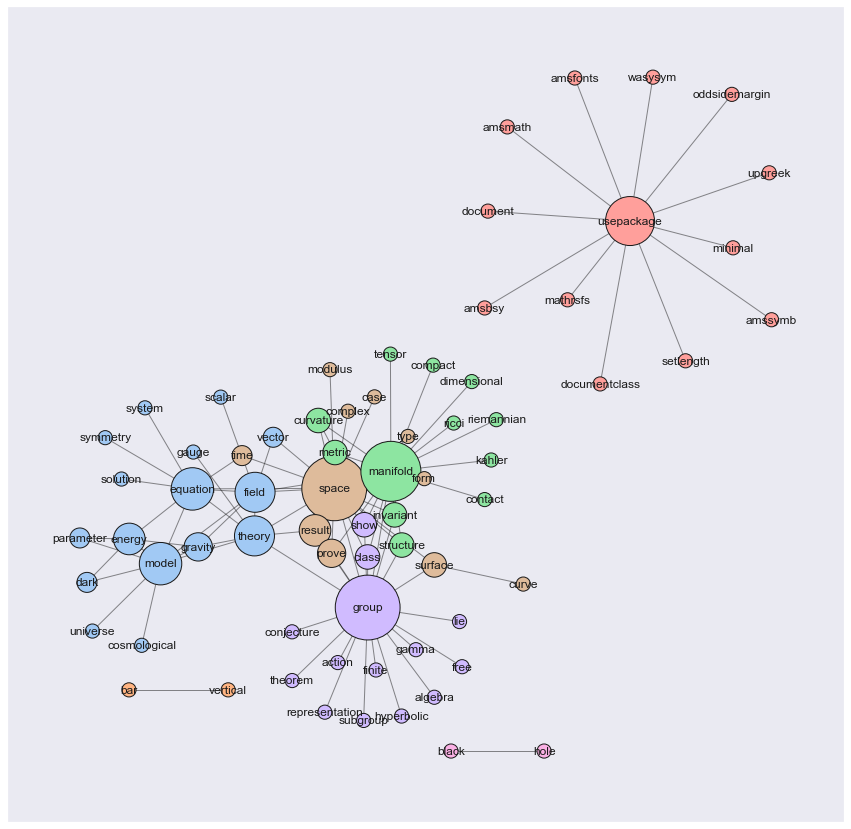

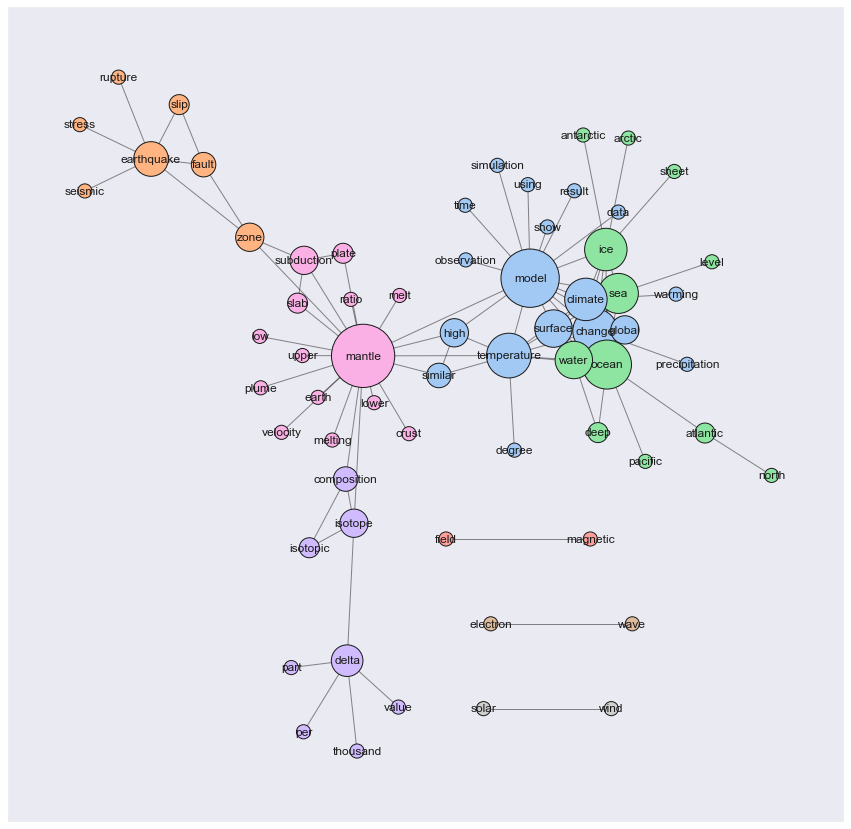

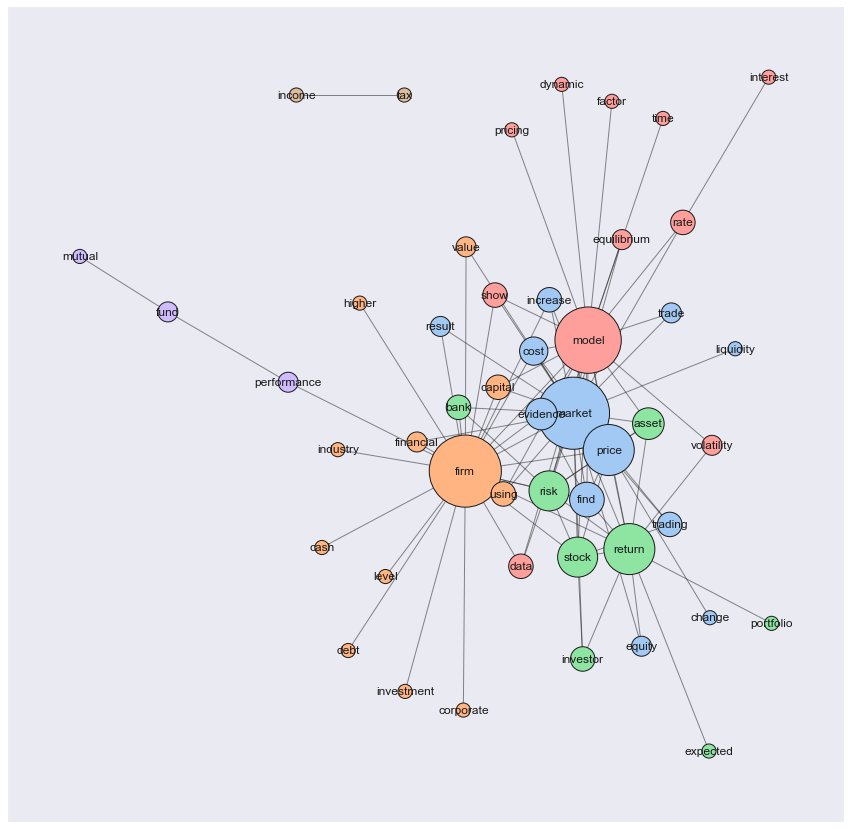

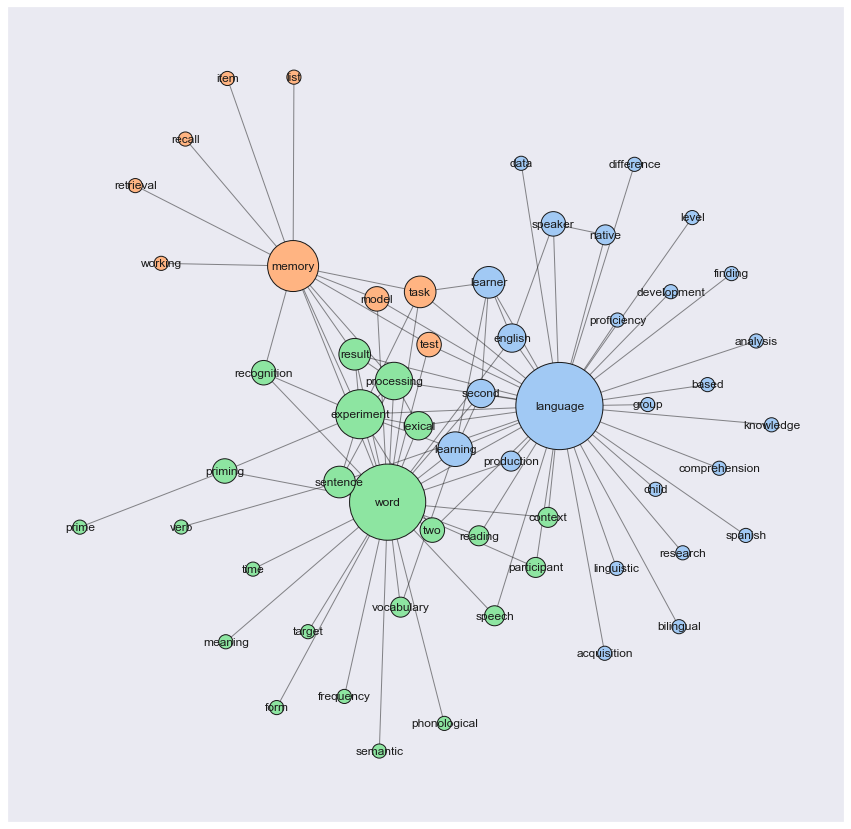

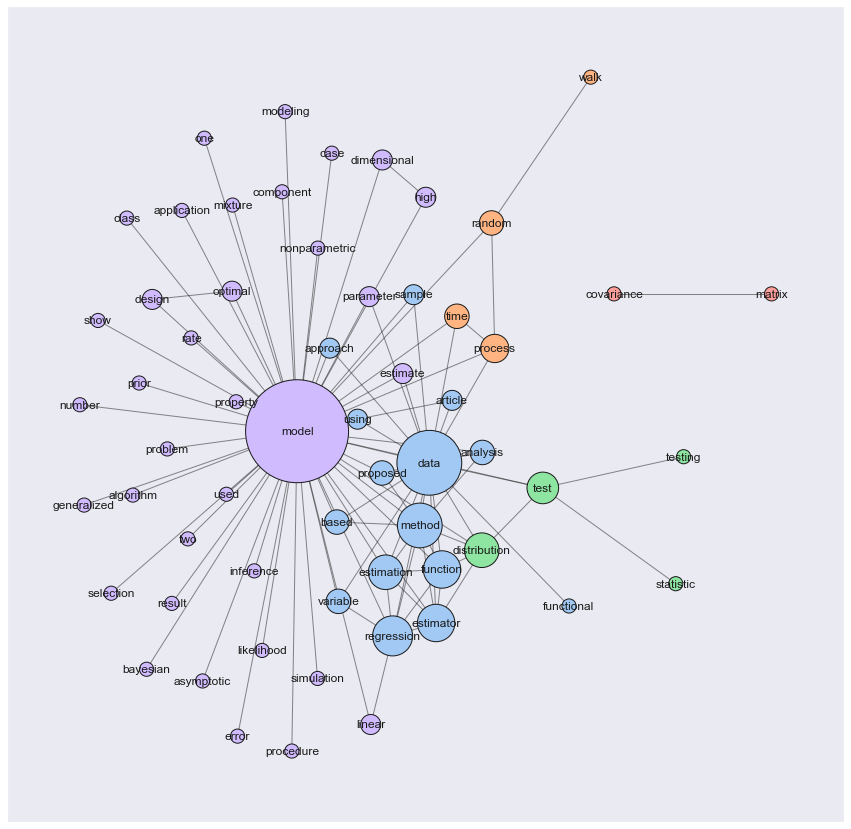

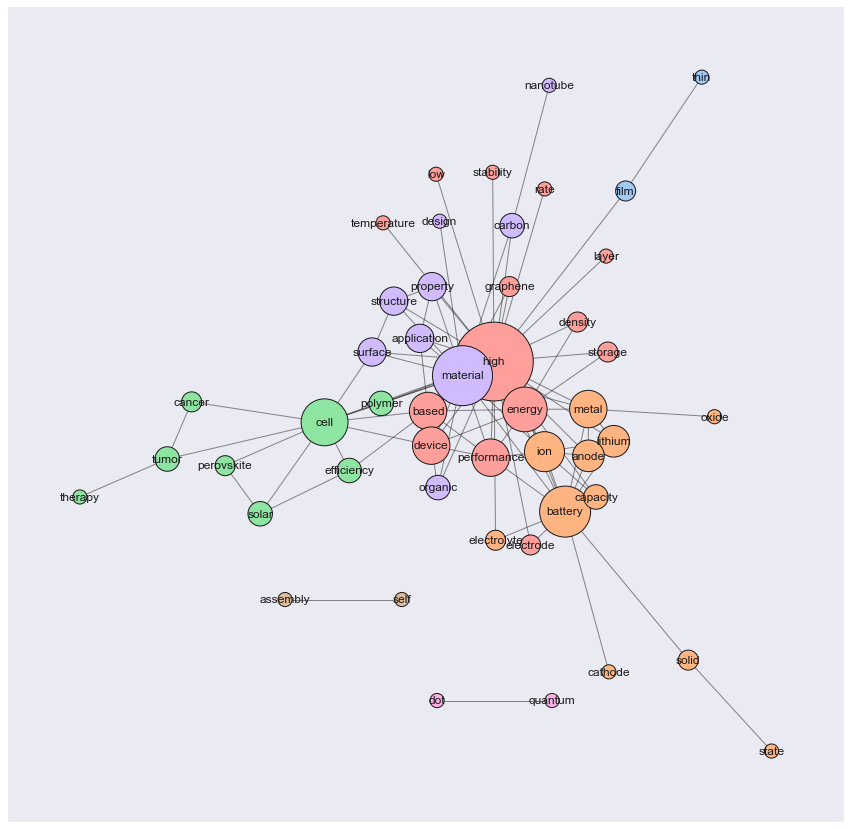

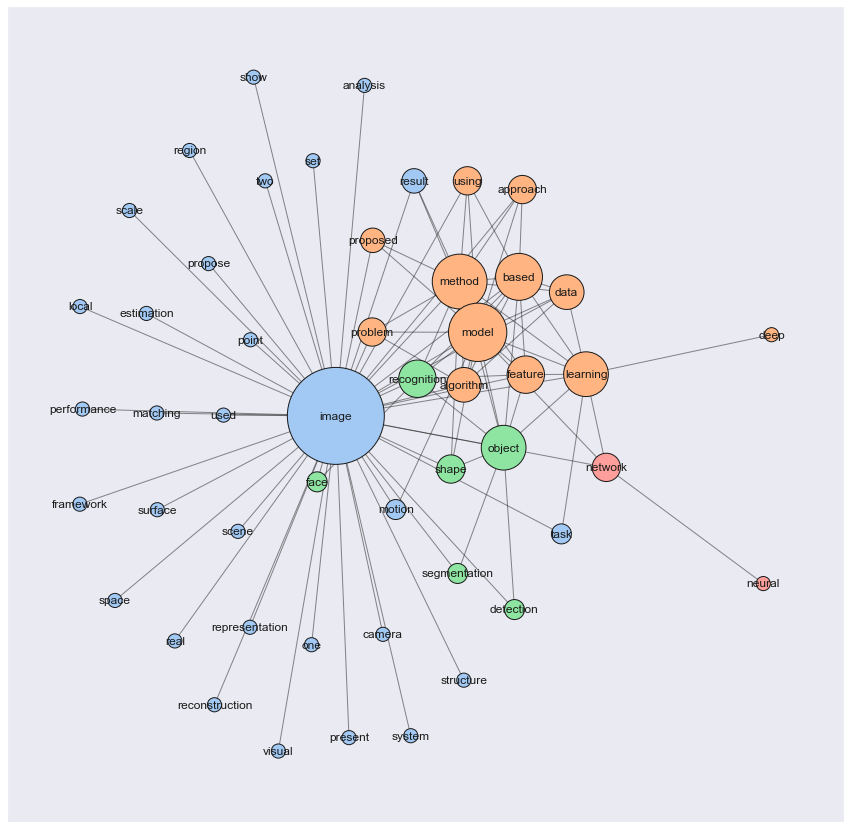

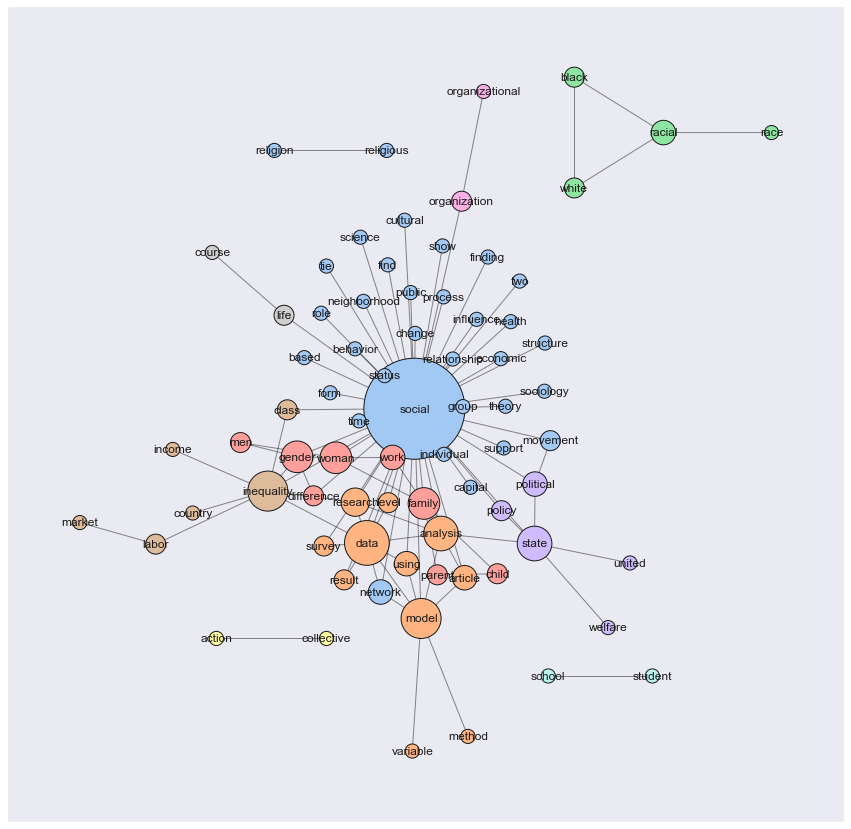

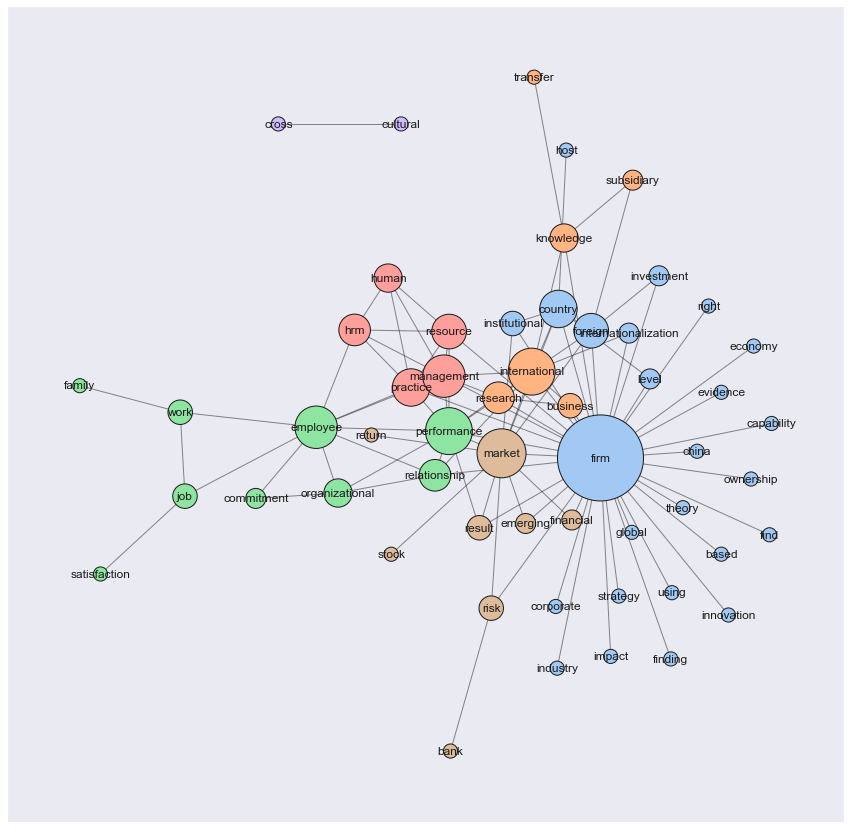

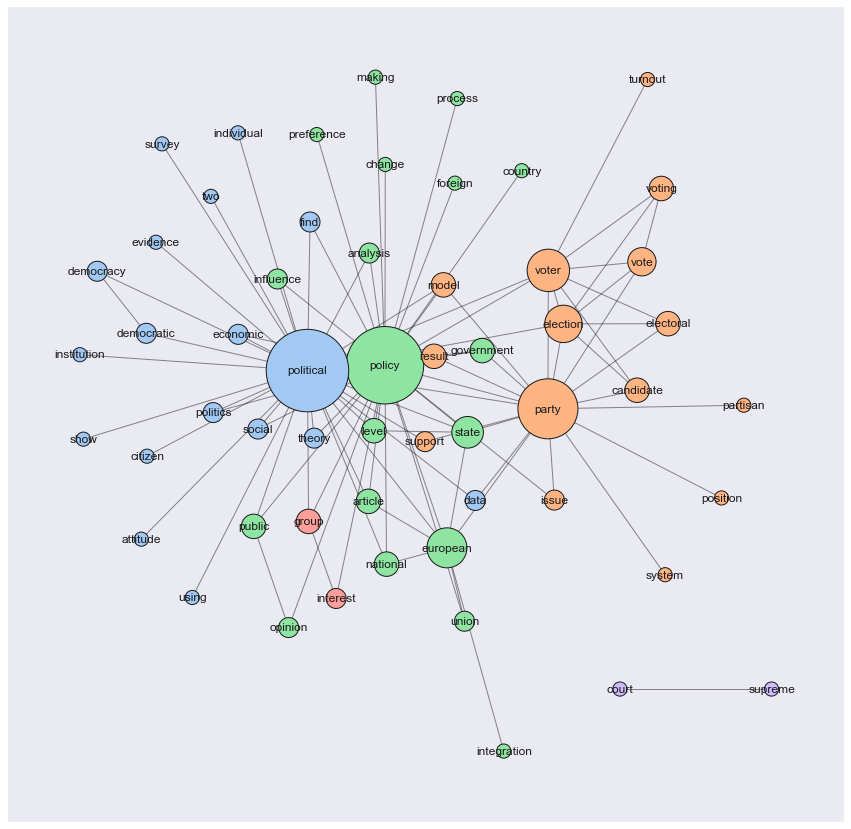

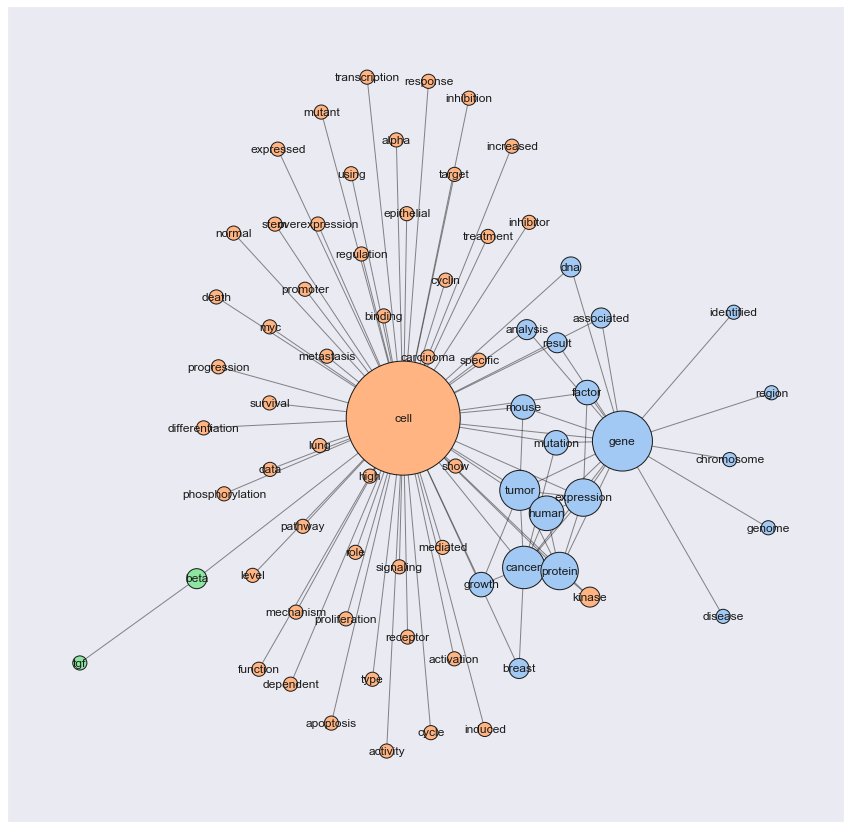

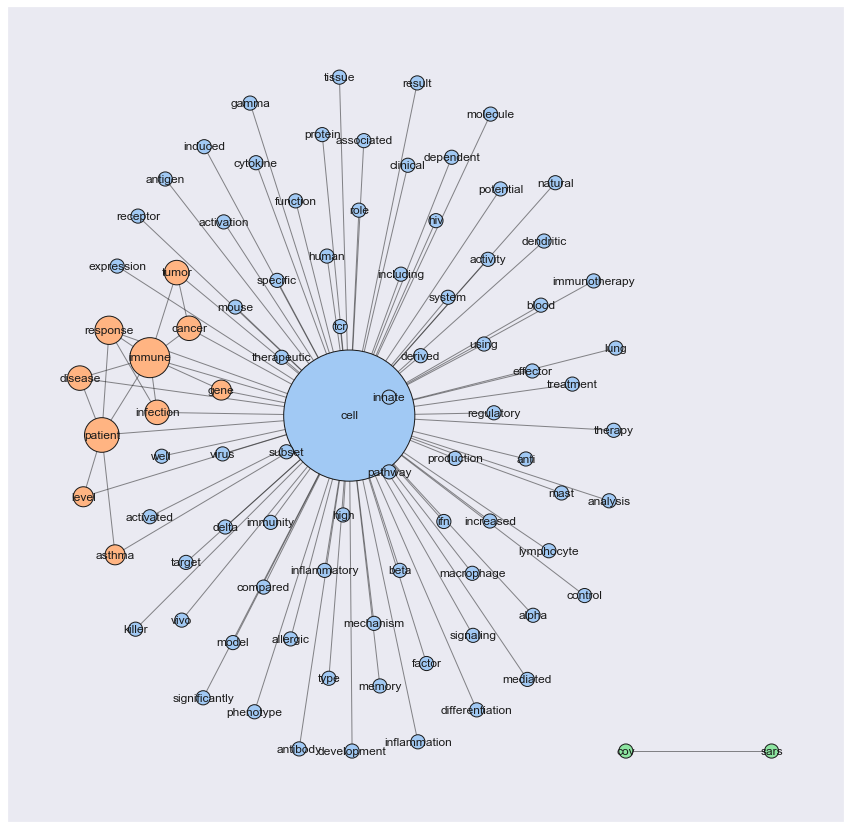

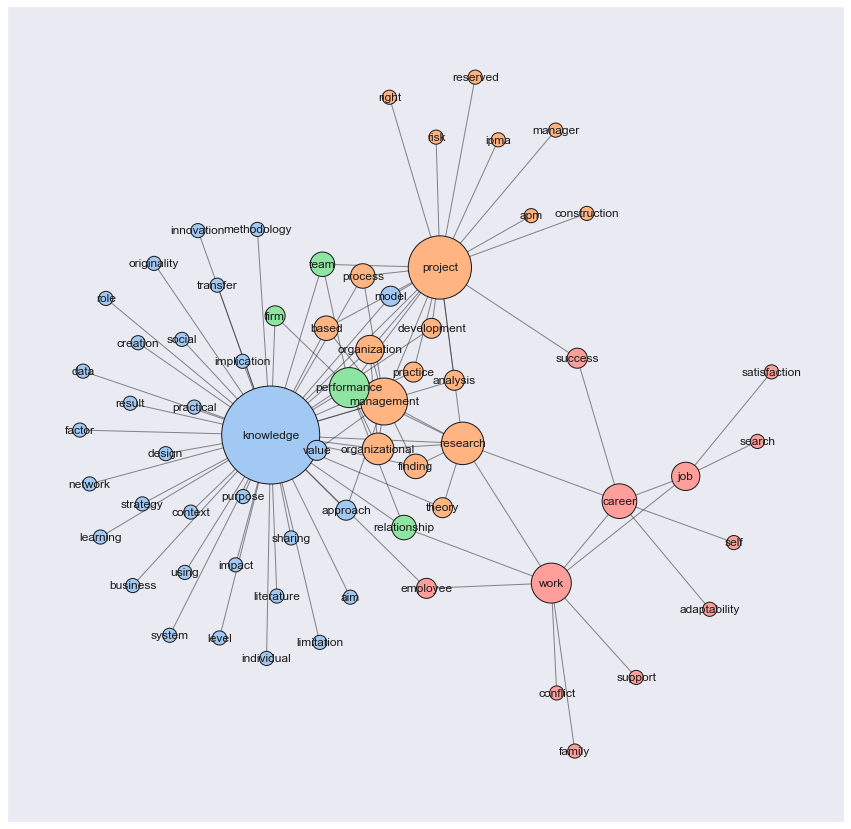

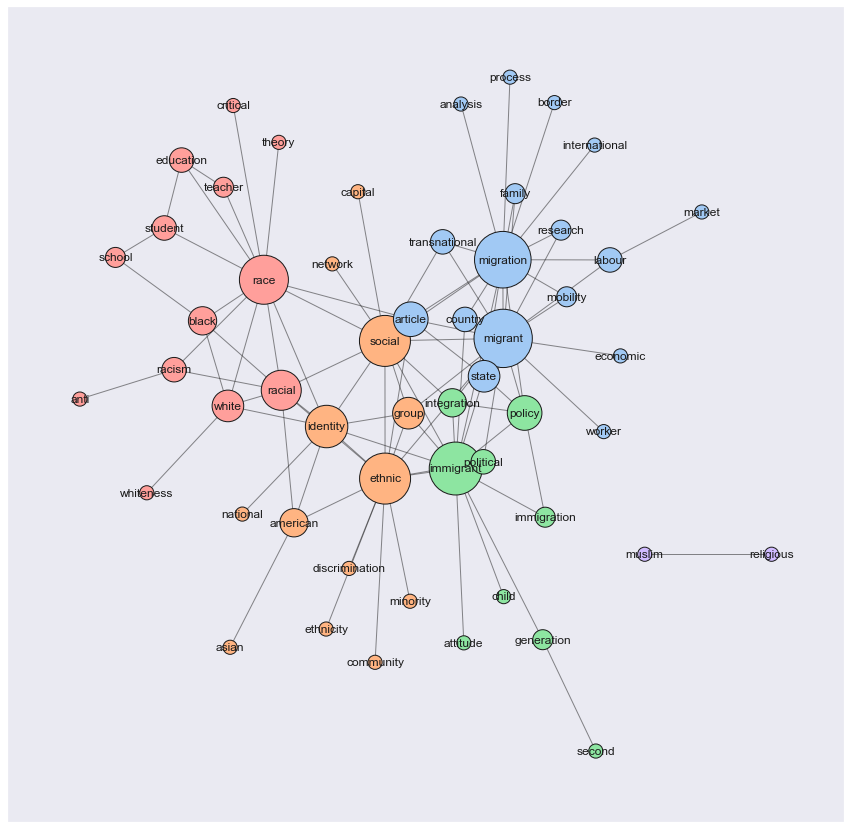

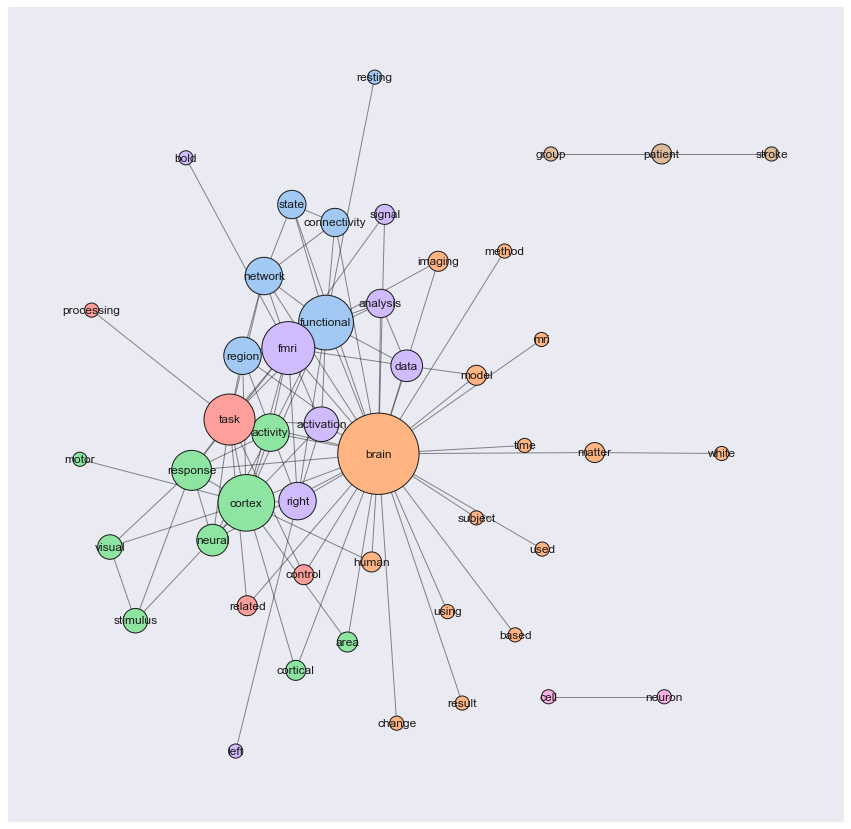

In [8]:
communities=True
co_citation=False

for field_name, G in Gs.items():

    print(field_name)
    
    fig, ax = plt.subplots(1, figsize=(15, 15))

    node_deg = dict(nx.degree(G))
    node_names = list(node_deg.keys())
    node_sizes = list(map(lambda deg: deg*200, node_deg.values()))
    node_labels = dict(zip(node_names, node_names))

    new_node_labels = (
        pl.read_parquet(f'./output/main_dfs/{field_name}.parquet')
        .select(
            pl.col('Doi'), 
            pl.concat_str([
                pl.lit('('),
                pl.col('Authors').arr.first().str.split(', ').arr.first(),
                pl.lit(', '),
                pl.col('Date').dt.year(),
                pl.lit(')')
            ])
        )
        .filter(pl.col('Doi').is_in(node_names))
        .to_numpy()
    )

    new_node_labels = dict(map(tuple, new_node_labels))
    if co_citation:
        node_labels.update(new_node_labels)

    if communities:
        comms = nx_comm.louvain_communities(G)
        palette = sns.color_palette("pastel", len(comms))
        node_color_map = {}
        for comm, color in zip(comms, palette):
            for node in comm:
                node_color_map[node] = color
        node_color = [node_color_map[n] for n in G.nodes]
        node_color

    pos = nx.nx_agraph.graphviz_layout(G, prog='sfdp') # dot, twopi, fdp, sfdp, circo

    nx.draw_networkx_nodes(
        G, 
        pos,
        nodelist=node_names,
        node_size=node_sizes,
        # node_color='#00ABB3',
        node_color=node_color,
        node_shape='o',
        alpha=None,
        cmap=plt.cm.Blues,
        ax=ax,
        linewidths=1.0,
        edgecolors='k',
    ).set_zorder(1)

    nx.draw_networkx_labels(G, pos=pos, ax=ax, labels=node_labels)

    nx.draw_networkx_edges(
        G, 
        pos,
        width=1.0,
        edge_color='k',
        style='solid',
        alpha=0.5,
        arrowsize=10,
        ax=ax,
        nodelist=node_names,
        node_size=node_sizes,
        node_shape='o',
        connectionstyle='arc3',
    ).set_zorder(-1)

    ax.grid(False)

    plt.savefig(
        os.path.join(LATEX_FIGURES_PATH, 'co_occurrence_graphs', f'{field_name.capitalize()}.png'), 
        transparent=True, 
        dpi=150 
    )

# HeatMap

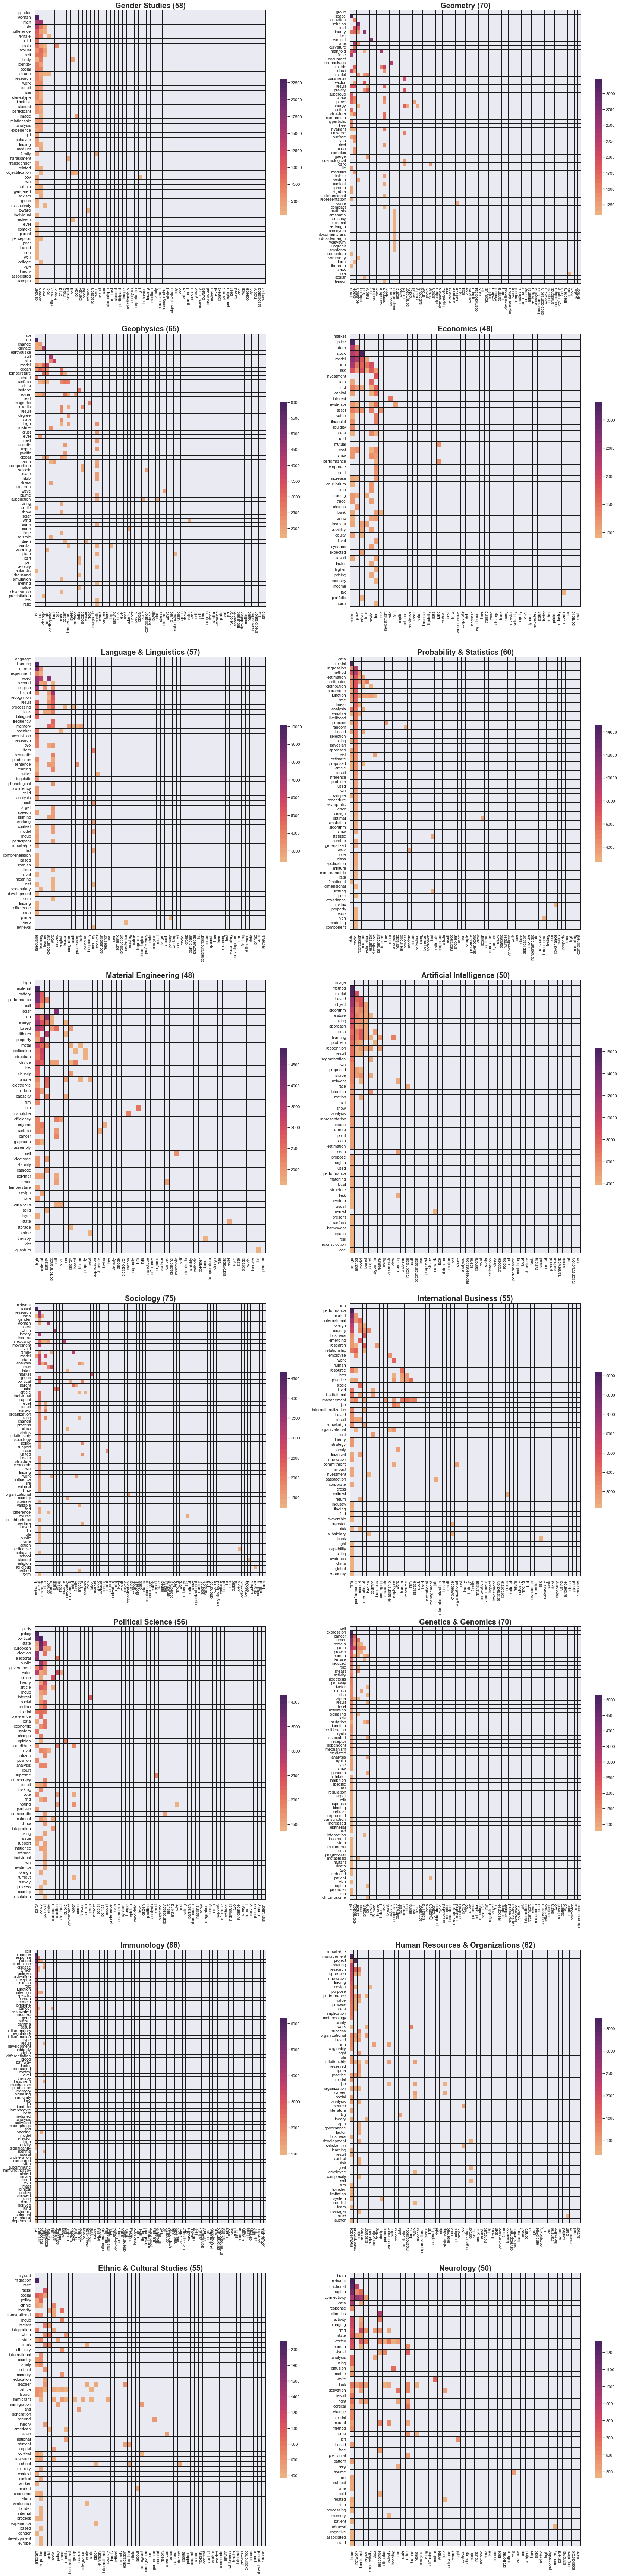

In [7]:
n_cols = 2
height = 12
width = 12
n_rows = np.ceil(len(Gs) / n_cols)

fig, axs = plt.subplots(int(n_rows), int(n_cols), figsize=(n_cols*height, n_rows*width))
for (field_name, G), ax in zip(Gs.items(), axs.flatten()):

    nodes = G.nodes
    am = nx.to_numpy_array(G)
    up_triang = np.triu(np.ones_like(am)).astype(bool)
    cmap = plt.get_cmap('flare',30)
    cmap.set_under('white')
    cmap.set_over('yellow')

    sns.heatmap(am, linewidth=.5, cmap=cmap, linecolor='k', linewidths=0.5, xticklabels=nodes, yticklabels=nodes, mask=(am==0) | (up_triang), ax=ax, cbar_kws={"shrink": 0.5})

    ax.set_title(f'{field_name} ({len(nodes)})', fontweight='semibold', fontsize=20)

    ax.set_xlim(0, len(G) + 0.1)
    ax.set_ylim(len(G) + 0.1, 0)
plt.tight_layout()
# plt.savefig(os.path.join(OBSIDIAN_IMG_PATH, 'co_occurence_heatmap.png'))
plt.show()


# Clusters

In [6]:
communities = {}
for field_name, G in Gs.items():
    communities[field_name] = nx_comm.louvain_communities(G)

In [7]:
{field_name: len(comms) for field_name, comms in communities.items()}

{'Gender Studies': 4,
 'Geometry': 7,
 'Geophysics': 9,
 'Economics': 6,
 'Language & Linguistics': 3,
 'Probability & Statistics': 6,
 'Material Engineering': 7,
 'Artificial Intelligence': 4,
 'Sociology': 11,
 'International Business': 6,
 'Political Science': 4,
 'Genetics & Genomics': 3,
 'Immunology': 3,
 'Human Resources & Organizations': 4,
 'Ethnic & Cultural Studies': 5,
 'Neurology': 7}